# Tutorial 1: calibration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os

In [2]:
url = 'https://raw.githubusercontent.com/oguerrer/ppi_app/main/code/ppi.py'
r = requests.get(url)
with open('ppi.py', 'w') as f:
    f.write(r.text)
import ppi

url = 'https://raw.githubusercontent.com/oguerrer/ppi_app/main/code/calibrator.py'
r = requests.get(url)
with open('calibrator.py', 'w') as f:
    f.write(r.text)
import calibrator

### Download datasets

In [3]:
file_names = ['expenditure_matrix_imperfect', 'expenditure_matrix_perfect', 'expenditure_mean',
        'expenditure_serie', 'indicators_properties', 'indicators_series', 'network']

for file_name in file_names:
    url = 'https://raw.githubusercontent.com/oguerrer/ppi_app/main/data/benchmark/'+file_name+'.csv'
    r = requests.get(url)
    with open(os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())

### Calibration with indicator time series only

In [4]:
# Load indicators
series = np.loadtxt('indicators_series.csv', delimiter=',', dtype=float)
# Get initial values
I0 = series[:,0]
# Get final values
IF = series[:,-1]
# Get success rates
success_rates = np.sum(series[:,1::] < series[:,0:-1], axis=1)/(series.shape[1]-1)

In [5]:
parameters = calibrator.calibrate(I0, IF, success_rates, parallel_processes=20)
df_indicators_series = pd.DataFrame(parameters[1::,:], columns=parameters[0])

### Calibration with single total budget

In [6]:
budget = np.loadtxt('expenditure_mean.csv', delimiter=',', dtype=float)
Bs = float(budget)

In [7]:
parameters = calibrator.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs)
df_expenditure_mean = pd.DataFrame(parameters[1::,:], columns=parameters[0])

### Calibration with total budget time series

In [8]:
budget = np.loadtxt('expenditure_serie.csv', delimiter=',', dtype=float)
Bs = budget

In [9]:
parameters = calibrator.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs)
df_expenditure_serie = pd.DataFrame(parameters[1::,:], columns=parameters[0])

### Calibration with perfect budget matrix

In [10]:
budget = np.loadtxt('expenditure_matrix_perfect.csv', delimiter=',', dtype=float)
Bs = budget
B_dict = {}
for i in range(len(I0)):
    B_dict[i] = [i]

In [11]:
parameters = calibrator.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs, B_dict=B_dict)
df_expenditure_matrix_perfect = pd.DataFrame(parameters[1::,:], columns=parameters[0])

### Calibration with imperfect budget matrix

In [12]:
budget = np.loadtxt('expenditure_matrix_imperfect.csv', delimiter=',', dtype=float)
Bs = budget
B_dict = {}
j = 0
for i in range(len(I0)):
    B_dict[i] = [j]
    if i%2==0 and j<len(Bs)-1:
        j+=1

In [13]:
parameters = calibrator.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs, B_dict=B_dict)
df_expenditure_matrix_imperfect = pd.DataFrame(parameters[1::,:], columns=parameters[0])

### Calibration with indicator properties

In [14]:
df2 = pd.read_csv('indicators_properties.csv')
# instrumental indicators
R = df2.instrumental.values
# quality of monitoring
qm = df2.controlOfCorruption.values[R==1]
# quality of monitoring
rl = df2.ruleOfLaw.values[R==1]
# spillover network
A = np.loadtxt('network.csv', delimiter=',', dtype=float)

# update B_dict to consider instrumental indicators only
B_dict = {}
j = 0
for i in range(len(I0)):
    if R[i] == 1:
        B_dict[i] = [j]
        if i%2==0 and j<len(Bs)-1:
            j+=1

In [15]:
parameters = calibrator.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs, B_dict=B_dict, 
                                  A=A, R=R, qm=qm, rl=rl)
dfp1 = pd.DataFrame(parameters[1::,:], columns=parameters[0])

### Verify robustness between two independent calibrations

In [16]:
parameters = calibrator.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs, B_dict=B_dict, 
                                  R=R, qm=qm, rl=rl)
dfp2 = pd.DataFrame(parameters[1::,:], columns=parameters[0])

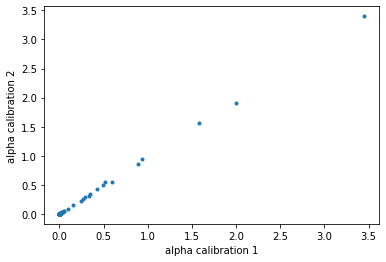

In [17]:
plt.plot(dfp1.alpha, dfp2.alpha, '.')
plt.xlabel('alpha calibration 1')
plt.ylabel('alpha calibration 2')
plt.show()

### Prospective simulations

In [18]:
# projected budget matrix
Bs_future = np.tile(Bs[:,-1], (20,1)).T
# Minimum and maximum values
Imin = np.zeros(len(I0))
Imax = np.ones(len(I0))
# paramters
alphas = dfp2.alpha.values.astype(float)
alphas_prime = dfp2.alpha_prime.values.astype(float)
betas = dfp2.beta.values.astype(float)

A single simulation

In [19]:
outputs = ppi.run_ppi(I0=I0, alphas=alphas, alphas_prime=alphas_prime, 
                          betas=betas, A=A, R=R, qm=qm, rl=rl,
                          Bs=Bs_future, B_dict=B_dict, Imin=Imin, Imax=Imax)

# unpack matrices with time series
tsI, tsC, tsF, tsP, tsS, tsG = outputs

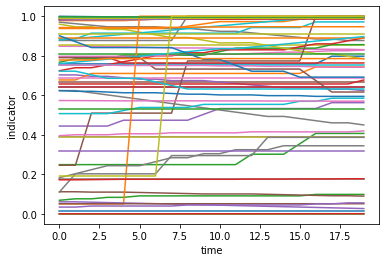

In [20]:
# plot projected time series
for serie in tsI:
    plt.plot(serie)
plt.xlabel('time')
plt.ylabel('indicator')
plt.show()

Several simulations and taking the average dynamics

In [21]:
all_outputs = []
for sim in range(100):
    outputs = ppi.run_ppi(I0=I0, alphas=alphas, alphas_prime=alphas_prime, 
                          betas=betas, A=A, R=R, qm=qm, rl=rl,
                          Bs=Bs_future, B_dict=B_dict, Imin=Imin, Imax=Imax)
    all_outputs.append(outputs)

# unpack Monte Carlo samples
tsI, tsC, tsF, tsP, tsS, tsG = zip(*all_outputs)
# compute means
mean_tsI = np.mean(tsI, axis=0)

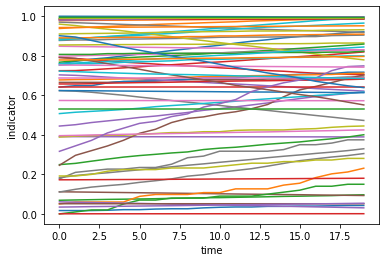

In [22]:
# plot projected time series
for serie in mean_tsI:
    plt.plot(serie)
plt.xlabel('time')
plt.ylabel('indicator')
plt.show()

A counterfactual with double the budget

In [23]:
all_outputs = []
for sim in range(100):
    outputs = ppi.run_ppi(I0=I0, alphas=alphas, alphas_prime=alphas_prime, 
                          betas=betas, A=A, R=R, qm=qm, rl=rl,
                          Bs=2*Bs_future, B_dict=B_dict, Imin=Imin, Imax=Imax)
    all_outputs.append(outputs)

# unpack Monte Carlo samples
tsI, tsC, tsF, tsP, tsS, tsG = zip(*all_outputs)
# compute means
mean_tsI = np.mean(tsI, axis=0)

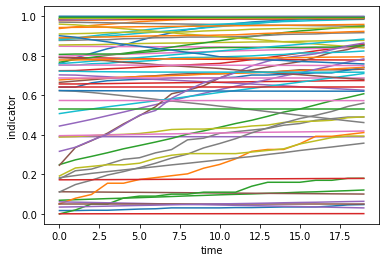

In [24]:
# plot projected time series
for serie in mean_tsI:
    plt.plot(serie)
plt.xlabel('time')
plt.ylabel('indicator')
plt.show()